# 智慧海洋建设-地理数据分析常用工具

## 学习目标

1.了解和学习shapely和geopandas的基本功能，掌握用python中的这两个库实现几何对象之间的空间操作方法。

2.掌握folium和kepler.gl的数据可视化工具的使用。

3.学习与掌握geohash编码方法。

## 学习内容

### 一、shapely

In [2]:
from shapely import geometry as geo
from shapely import wkt 
from shapely import ops
import numpy as np 

#### 1. Point对象

In [6]:
# 创建Point对象
point1 = geo.Point(0,0)
point2 = geo.Point([0,1])
point3 = wkt.loads("POINT(1 1)")
print(point1)
print(point2)
print(point3)

POINT (0 0)
POINT (0 1)
POINT (1 1)


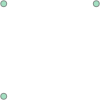

In [12]:
# 批量可视化
geo.GeometryCollection([point1, point2, point3])

In [14]:
# 对象属性
print(point3.x, point3.y)
print(list(point3.coords))
print(np.array(point3))  # 可以和array互转

1.0 1.0
[(1.0, 1.0)]
[1. 1.]


In [17]:
# 计算距离
point1.distance(point3)

1.4142135623730951

#### 2.LineString对象
构造函数传入参数是两个或多个点元组

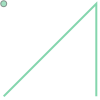

In [20]:
arr = [(0,0), (1,1), (1,0)]
line = geo.LineString(arr)
point = geo.Point(0, 1)
geo.GeometryCollection([line, point]) # 支持多种对象

In [21]:
# 两个几何对象之间的距离：线线距离或点线距离
point.distance(line)

0.7071067811865476

In [22]:
# 两个几何对象之间的hausdorff_distance距离
point.hausdorff_distance(line) # 求的是点与线的最长距离

1.4142135623730951

In [26]:
# 对象属性
print('该几何对象的面积:', line.area)
print('该几何对象的坐标范围:', line.bounds)
print('该几何对象的长度:', line.length)
print('该几何对象的几何类型:', line.geom_type)  
print('该几何对象的坐标系:', list(line.coords))

该几何对象的面积: 0.0
该几何对象的坐标范围: (0.0, 0.0, 1.0, 1.0)
该几何对象的长度: 2.414213562373095
该几何对象的几何类型: LineString
该几何对象的坐标系: [(0.0, 0.0), (1.0, 1.0), (1.0, 0.0)]


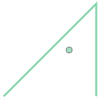

In [27]:
# 获取几何中心
center = line.centroid
geo.GeometryCollection([line,center])

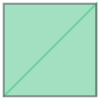

In [28]:
# 获取几何对象的最小外接矩形
bbox = line.envelope 
geo.GeometryCollection([line,bbox])

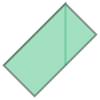

In [29]:
#获取几何对象的最小旋转外接矩形
rect = line.minimum_rotated_rectangle 
geo.GeometryCollection([line,rect])

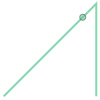

In [30]:
# 插值
pt_half = line.interpolate(0.5, normalized=True)
geo.GeometryCollection([line,pt_half])

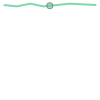

In [31]:
line1 = geo.LineString([(0,0),(1,-0.1),(2,0.1),(3,-0.1),(5,0.1),(7,0)])
pt_half1 = line1.interpolate(0.5, normalized=True)
geo.GeometryCollection([line1,pt_half1])

In [32]:
# project()方法是和interpolate方法互逆的
ratio = line.project(pt_half,normalized=True) 
print(ratio)

0.5


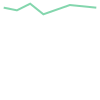

In [35]:
line1 = geo.LineString([(0,0),(1,-0.2),(2,0.3),(3,-0.5),(5,0.2),(7,0)])
line1

LINESTRING (0 0, 2 0.3, 3 -0.5, 5 0.2, 7 0)


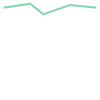

In [36]:
# Douglas-Pucker算法，多方向剖面线，轨迹分析时经常用得到
line1_simplify = line1.simplify(0.4, preserve_topology=False)
print(line1_simplify)
line1_simplify

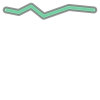

In [42]:
 #端点按照半圆扩展， cap_style指定拓展方式，join_style指定连接方式
buffer_with_circle = line1.buffer(0.2) 
geo.GeometryCollection([line1,buffer_with_circle])

#### 3.LinearRing对象
LinearRing对象构造函数传入参数是2个或多个点元组

元组序列可以通过在第一个和最后一个索引中传递相同的值来显式关闭。否则，将第一个元组复制到最后一个索引，从而隐式关闭序列。 与LineString一样，元组序列中的重复点是允许的，但可能会导致性能上的损失，应该避免在序列中设置重复点。

3.414213562373095
0.0


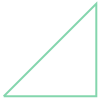

In [43]:
# from shapely.geometry.polygon import LinearRing
ring = geo.polygon.LinearRing([(0, 0), (1, 1), (1, 0)])
print(ring.length)#相比于刚才的LineString的代码示例，其长度现在是3.41，是因为其序列是闭合的
print(ring.area)
geo.GeometryCollection([ring])

#### 4.Polygon对象
Polygon接受两个位置参数，第一个位置参数是和LinearRing一样，是一个有序的point元组。第二个位置参数是可选的序列，其用来指定内部的边界

3.414213562373095
0.5


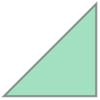

In [46]:
from shapely.geometry import Polygon
poly1 = geo.Polygon([(0, 0), (1, 1), (1, 0)])
print(poly1.length)
print(poly1.area) # 面积由0变成0.5
geo.GeometryCollection([poly1])

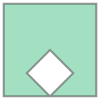

In [49]:
ext = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
inner = [(1, 0), (0.5, 0.5), (1, 1), (1.5, 0.5), (1, 0)]
polygon2 = Polygon(ext, [inner])
polygon2

In [50]:
print(polygon2.area)#其面积是ext的面积减去int的面积
print(polygon2.length)#其长度是ext的长度加上int的长度
print(np.array(polygon2.exterior))  #外围坐标点

3.5
10.82842712474619
[[0. 0.]
 [0. 2.]
 [2. 2.]
 [2. 0.]
 [0. 0.]]


#### 5. 几何对象关系
一个几何对象特征分别有interior、boundary和exterior。下面的叙述直接用内部、边界和外部等名词概述

1.object.contains(other)\
如果object的外部没有其他点，或者至少有一个点在该object的内部，则返回True\
a.contains(b)与 b.within(a)的表达是等价的

True


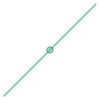

In [52]:
from shapely.geometry import LineString, Point
line = LineString([(0, 0), (1, 1)])
point1 = Point(0.5, 0.5)
print(line.contains(point1))#线与点的关系
geo.GeometryCollection([line, point1])

False


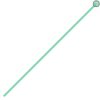

In [53]:
point2 = Point(1, 1)
print(line.contains(point2))
#因为line的边界不是属于在该对象的内部，所以返回是False
geo.GeometryCollection([line, point2])

False


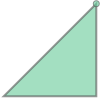

In [54]:
print(polygon1.contains(point2))#面与点的关系
#同理这个contains方法也可以扩展到面与线的关系以及面与面的关系
geo.GeometryCollection([polygon1,point2])

2.object.crosses(other)\
如果一个object与另一个object是内部相交的关系而不是包含的关系，则返回True

True


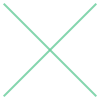

In [58]:
line2 = LineString([(0, 1), (1, 0)])
print(line.crosses(line2))
geo.GeometryCollection([line,line2])

False


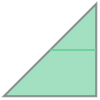

In [59]:
line3 = LineString([(0.5, 0.5), (1, 0.5)])
print(polygon1.crosses(line3))
geo.GeometryCollection([polygon1, line3])

3.object.disjoint(other)\
如果该对象与另一个对象的内部和边界都不相交则返回True

True


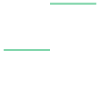

In [62]:
line4 =  LineString([(0, 0), (0.5, 0)])
print(line4.disjoint(line3))
geo.GeometryCollection([line4, line3])

4.object.intersects(other)\
如果该几何对象与另一个几何对象只要相交则返回True。

True


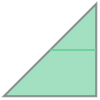

In [60]:
print(polygon1.intersects(line3))
geo.GeometryCollection([polygon1, line3])

5.object.convex_hull\
返回包含对象中所有点的最小凸多边形（凸包）

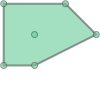

In [63]:
# 在下图中即为在给定6个point之后求其凸包，并绘制出来的凸包图形
points1 = geo.MultiPoint([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])
hull1 = points1.convex_hull
geo.GeometryCollection([hull1,points1])

6.object.intersection\
返回对象与对象之间的交集

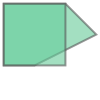

In [64]:
polygon1 = Polygon( [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)])
geo.GeometryCollection([hull1,polygon1])

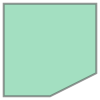

In [65]:
hull1.intersection(polygon1)

7.object.union\
返回对象与对象之间的并集

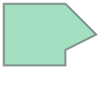

In [66]:
hull1.union(polygon1)

8.object.difference\
返回对象与对象之间的补集

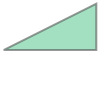

In [68]:
polygon1.difference(hull1)

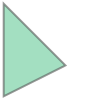

In [69]:
hull1.difference(polygon1)

与numpy和python数组之间的关系\
point、LineRing和LineString提供numpy数组接口，可以进行转换numpy数组

In [70]:
from shapely.geometry import asPoint,asLineString,asMultiPoint,asPolygon
import numpy as np
pa = asPoint(np.array([0.0, 0.0]))#将numpy数组转换成point格式
la = asLineString(np.array([[1.0, 2.0], [3.0, 4.0]]))#将numpy数组转换成LineString格式
ma = asMultiPoint(np.array([[1.1, 2.2], [3.3, 4.4], [5.5, 6.6]]))#将numpy数组转换成multipoint集合
pg = asPolygon(np.array([[1.1, 2.2], [3.3, 4.4], [5.5, 6.6]]))#将numpy数组转换成polygon
print(np.array(pa))#将Point转换成numpy格式

[0. 0.]


另外还有一些非常有用但是不属于某个类方法的函数，如有需要可以在官网查阅
- ops.nearest_points 求最近点
- ops.split 分割线
- ops.substring 求子串
- affinity.rotate 旋转几何体
- affinity.scale 缩放几何体
- affinity.translate 平移几何体

### 2. geopandas

GeoPandas提供了地理空间数据的高级接口，它让使用python处理地理空间数据变得更容易。GeoPandas扩展了pandas。)使用的数据类型，允许对几何类型进行空间操作。几何运算由shapely执行。Geopandas进一步依赖fiona进行文件访问，依赖matplotlib进行绘图。


geopandas和pandas一样，一共有两种数据类型：
- GeoSeries
- GeoDataFrame 它们继承了pandas数据结构的大部分方法。这两个数据结构可以当做地理空间数据的存储器，shapefile文件的pandas呈现。

Shapefile文件用于描述几何体对象：点，折线与多边形。例如，Shapefile文件可以存储井、河流、湖泊等空间对象的几何位置。除了几何位置，shp文件也可以存储这些空间对象的属性，例如一条河流的名字，一个城市的温度等等。

例如，当安装geopandas库后，便可通过matplotlib直接画出当安装geopandas数据集中的世界地图


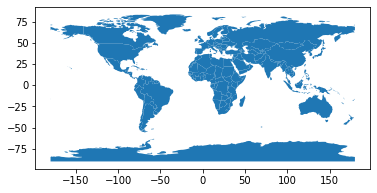

In [72]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))#read_file方法可以读取shape文件，转化为GeoSeries和GeoDataFrame数据类型。
world.plot()#将GeoDataFrame变成图形展示出来，得到世界地图
plt.show()

In [73]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


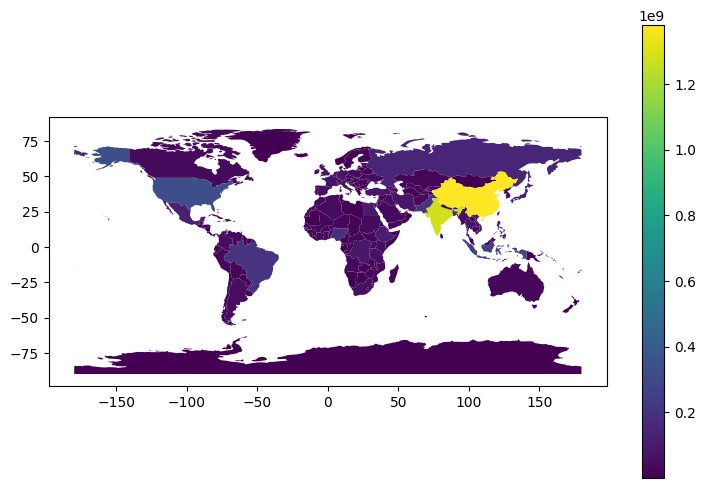

In [74]:
#根据每一个polygon的pop_est不同，便可以用python绘制图表显示不同国家的人数
fig, ax = plt.subplots(figsize=(9,6),dpi = 100)
world.plot('pop_est',ax = ax,legend = True)
plt.show()


由以上geodataframe的实例world可知，其最后一列是geometry。其几何对象包括了MULTIPOLYGON 、POLYGON，那么便同样可以用刚才介绍的shapely库进行分析。\

具体的geopadandas常用的方法可以参考这篇文章 https://www.cnblogs.com/giserliu/p/4988615.html \
geopdandas的相关中文案例和分析可参考这个集锦，了解一下具体使用情况
https://mp.weixin.qq.com/mp/appmsgalbum?action=getalbum&__biz=MzA3ODYwNDkzOQ==&scene=1&album_id=1342860388945444864&count=3#wechat_redirect

### 3. Folium

folium可以满足我们平时常用的热力图、填充地图、路径图、散点标记等高频可视化场景。folium也可以通过flask让地图和我们的数据在网页上显示，极其便利

In [77]:
import folium
import os
#首先，创建一张指定中心坐标的地图，这里将其中心坐标设置为北京。
# zoom_start表示初始地图的缩放尺寸，数值越大放大程度越大
m=folium.Map(location=[39.9,116.4],zoom_start=10)
m

In [79]:
# 用Folium绘制热力图
from folium.plugins import HeatMap
#先手动生成data数据，该数据格式由[纬度，经度，数值]构成
data=(np.random.normal(size=(100,3))*np.array([[1,1,1]])+np.array([[48,5,1]])).tolist()


In [80]:
m=folium.Map([48,5],tiles='stamentoner',zoom_start=6)
HeatMap(data).add_to(m)
m

官方文档：https://python-visualization.github.io/folium/index.html \
其他使用：https://www.zhihu.com/question/33783546

### 4. Kepler.gl
基础教程：https://sspai.com/post/55655
官网：https://kepler.gl

Kepler.gl与folium类似，也是是一个图形化的数据可视化工具，基于Uber的大数据可视化开源项目deck.gl创建的demo app。目前支持3种数据格式：CSV、JSON、GeoJSON。

Kepler.gl官网提供了可视化图形案例，分别是Arc（弧）、Line（线）、Hexagon（六边形）、Point（点）、Heatmap（等高线图）、GeoJSON、Buildings（建筑）。

下面用本赛题的数据进行简单的数据处理和基本的kepler.gl的使用

In [3]:
import pandas as pd 
import geopandas as gpd
from pyproj import Proj 
from keplergl import KeplerGl
from tqdm import tqdm
import os 
import matplotlib.pyplot as plt
import shapely
import numpy as np
from datetime import datetime  
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimSun']    # 指定默认字体为新宋体。
plt.rcParams['axes.unicode_minus'] = False      # 解决保存图像时 负号'-' 显示为方块和报错的问题。

In [84]:
#获取文件夹中的数据
def get_data(file_path,model):
    assert model in ['train', 'test'], '{} Not Support this type of file'.format(model)
    paths = os.listdir(file_path)
    print(len(paths))
    tmp = []
    for t in  tqdm(range(len(paths))):
        p = paths[t]
        with open('{}/{}'.format(file_path, p), encoding='utf-8') as f:
            next(f)
            for line in f.readlines():
                tmp.append(line.strip().split(','))
    tmp_df = pd.DataFrame(tmp)
    if model == 'train':
        tmp_df.columns = ['ID', 'lat', 'lon', 'speed', 'direction', 'time', 'type']
    else:
        tmp_df['type'] = 'unknown'
        tmp_df.columns = ['ID', 'lat', 'lon', 'speed', 'direction', 'time', 'type']
    tmp_df['lat'] = tmp_df['lat'].astype(float)
    tmp_df['lon'] = tmp_df['lon'].astype(float)
    tmp_df['speed'] = tmp_df['speed'].astype(float)
    tmp_df['direction'] = tmp_df['direction'].astype(float)
    tmp_df = tmp_df.convert_dtypes()
#     tmp_df['direction'] = tmp_df['direction'].astype(int)#如果该行代码运行失败，请尝试更新pandas的版本
    return tmp_df

In [85]:
# 平面坐标转经纬度，供初赛数据使用
# 选择标准为NAD83 / California zone 6 (ftUS) (EPSG:2230)，查询链接：https://mygeodata.cloud/cs2cs/
def transform_xy2lonlat(df):
    '''
    format ='+proj=lcc +lat_0=0 +lon_0=117 +k=1+z_0=500000 +y_0=0 +ellps=VGS84 +units=m +no_defs' 
    +proj= name:这是经常必选的一个地图投影转换函数。Name是一个投影名称
    +lon 0=c:设置中央经线。通常和+lat_0,一起决定投影的地理起点
    +lat O=d:设置纬度起点。通常和+lon_0,一起决定投影的地理起点
    +k:比例系数(比例因子)
    +x_0=x0:设置假东，例如在gauss - kruge中，东偏500000米。主要用来保持坐标的非负
    +y_0=y0:设置假北，主要用来保持坐标非负
    +ellps=acronym:选择一个proj里的椭球体。Acronym为椭球体名
    +units=name:设置地图坐标的单位
    +no defs:不要使用proj库中的缺省定义文件
    '''
    format_ = '+proj=lcc +lat_1=33.88333333333333 +lat_2=32.78333333333333 +lat_0=32.16666666666666 +lon_0=-116.25 +x_0=2000000.0001016 +y_0=500000.0001016001 +datum=NAD83 +units=us-ft +no_defs '
    x = df['lat'].values
    y = df['lon'].values
    p=Proj(format_)
    df['lon'], df['lat'] = p(y, x, inverse=True)
    return df  

In [86]:
#修改数据的时间格式
def reformat_strtime(time_str=None, START_YEAR="2019"):
    """Reformat the strtime with the form '08 14' to 'START_YEAR-08-14' """
    time_str_split = time_str.split(" ")
    time_str_reformat = START_YEAR + "-" + time_str_split[0][:2] + "-" + time_str_split[0][2:4]
    time_str_reformat = time_str_reformat + " " + time_str_split[1]
#     time_reformat=datetime.strptime(time_str_reformat,'%Y-%m-%d %H:%M:%S')
    return time_str_reformat
#计算两个点的距离
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km * 1000

In [87]:
def compute_traj_diff_time_distance(traj=None):
    """Compute the sampling time and the coordinate distance."""
    # 计算时间的差值
    time_diff_array = (traj["time"].iloc[1:].reset_index(drop=True) - traj[
        "time"].iloc[:-1].reset_index(drop=True)).dt.total_seconds() / 60

    # 计算坐标之间的距离
    dist_diff_array = haversine_np(traj["lon"].values[1:],  # lon_0
                                   traj["lat"].values[1:],  # lat_0
                                   traj["lon"].values[:-1], # lon_1
                                   traj["lat"].values[:-1]  # lat_1
                                   )

    # 填充第一个值
    time_diff_array = [time_diff_array.mean()] + time_diff_array.tolist()
    dist_diff_array = [dist_diff_array.mean()] + dist_diff_array.tolist()
    traj.loc[list(traj.index),'time_array'] = time_diff_array
    traj.loc[list(traj.index),'dist_array'] = dist_diff_array
    return traj 

In [88]:
#对轨迹进行异常点的剔除
def assign_traj_anomaly_points_nan(traj=None, speed_maximum=23,
                                   time_interval_maximum=200,
                                   coord_speed_maximum=700):
    """Assign the anomaly points in traj to np.nan."""
    def thigma_data(data_y,n): 
        data_x =[i for i in range(len(data_y))]
        ymean = np.mean(data_y)
        ystd = np.std(data_y)
        threshold1 = ymean - n * ystd
        threshold2 = ymean + n * ystd
        judge=[]
        for data in data_y:
            if (data < threshold1)|(data> threshold2):
                judge.append(True)
            else:
                judge.append(False)
        return judge
    # Step 1: The speed anomaly repairing
    is_speed_anomaly = (traj["speed"] > speed_maximum) | (traj["speed"] < 0)
    traj["speed"][is_speed_anomaly] = np.nan

    # Step 2: 根据距离和时间计算速度
    is_anomaly = np.array([False] * len(traj))
    traj["coord_speed"] = traj["dist_array"] / traj["time_array"]
    
    # Condition 1: 根据3-sigma算法剔除coord speed以及较大时间间隔的点
    is_anomaly_tmp = pd.Series(thigma_data(traj["time_array"],3)) | pd.Series(thigma_data(traj["coord_speed"],3))
    is_anomaly = is_anomaly | is_anomaly_tmp
    is_anomaly.index=traj.index
    # Condition 2: 轨迹点的3-sigma异常处理
    traj = traj[~is_anomaly].reset_index(drop=True)
    is_anomaly = np.array([False] * len(traj))

    if len(traj) != 0:
        lon_std, lon_mean = traj["lon"].std(), traj["lon"].mean()
        lat_std, lat_mean = traj["lat"].std(), traj["lat"].mean()
        lon_low, lon_high = lon_mean - 3 * lon_std, lon_mean + 3 * lon_std
        lat_low, lat_high = lat_mean - 3 * lat_std, lat_mean + 3 * lat_std

        is_anomaly = is_anomaly | (traj["lon"] > lon_high) | ((traj["lon"] < lon_low))
        is_anomaly = is_anomaly | (traj["lat"] > lat_high) | ((traj["lat"] < lat_low))
        traj = traj[~is_anomaly].reset_index(drop=True)
    return traj, [len(is_speed_anomaly) - len(traj)]

In [95]:
df=get_data('data/hy_round1_train_20200102/','train')

  1%|          | 43/7000 [00:00<00:16, 423.64it/s]

7000


100%|██████████| 7000/7000 [00:21<00:00, 322.45it/s]


In [96]:
df=transform_xy2lonlat(df)
df['time']=df['time'].apply(reformat_strtime)
df['time']=df['time'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

In [98]:
#这一个cell的代码不用运行，DF.csv该数据已经放到了github上面给出的附件数据里面

#对轨迹进行异常点剔除，对nan值进行线性插值
ID_list=list(pd.DataFrame(df['ID'].value_counts()).index)
DF_NEW=[]
Anomaly_count=[]
for ID in tqdm(ID_list):
    df_id=compute_traj_diff_time_distance(df[df['ID']==ID])
    df_new,count=assign_traj_anomaly_points_nan(df_id)
    df_new["speed"] = df_new["speed"].interpolate(method="linear", axis=0)
    df_new = df_new.fillna(method="bfill")
    df_new = df_new.fillna(method="ffill")
    df_new["speed"] = df_new["speed"].clip(0, 23)
    Anomaly_count.append(count)#统计每个id异常点的数量有多少
    DF_NEW.append(df_new)
DF=pd.concat(DF_NEW)

In [15]:
#读取github的数据
DF=pd.read_csv('data/DF.csv')

In [101]:
DF.head()

,Unnamed: 0,ID,lat,lon,speed,direction,time,type,time_array,dist_array,coord_speed
0,0,4924,44.878993,-121.048498,0.38,103,2019-11-13 23:59:30,围网,-1.088487,19.788529,-18.179848
1,1,4924,44.878993,-121.048498,0.05,0,2019-11-13 23:58:27,围网,-1.050000,0.000000,-0.000000
2,2,4924,44.878993,-121.048498,0.00,0,2019-11-13 23:57:24,围网,-1.050000,0.000000,-0.000000
3,3,4924,44.878993,-121.048498,0.05,0,2019-11-13 23:56:20,围网,-1.066667,0.000000,-0.000000
4,4,4924,44.878993,-121.048498,0.05,0,2019-11-13 23:55:17,围网,-1.050000,0.000000,-0.000000


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimSun


化简前数据长度：377
化简后数据长度：156


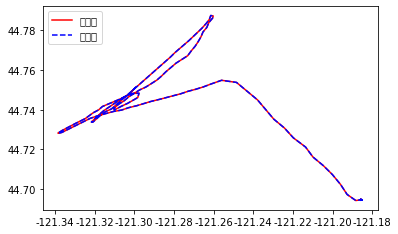

In [100]:
#douglas-peucker案例，由该案例可以看出针对相同ID的轨迹，可以先用geopandas将其进行简化和数据压缩
line= shapely.geometry.LineString(np.array(df[df['ID']=='11'][['lon','lat']]))
ax=gpd.GeoSeries([line]).plot(color='red')
ax = gpd.GeoSeries([line]).simplify(tolerance=0.000000001).plot(color='blue', 
                                                        ax=ax,
                                                        linestyle='--')
LegendElement = [plt.Line2D([], [], color='red', label='简化前'),
                 plt.Line2D([], [], color='blue', linestyle='--', label='简化后')]

# 将制作好的图例映射对象列表导入legend()中，并配置相关参数
ax.legend(handles = LegendElement, 
          loc='upper left', 
          fontsize=10)
# ax.set_ylim((-2.1, 1))
# ax.axis('off')
print('化简前数据长度：'+str(len(np.array(gpd.GeoSeries([line])[0]))))
print('化简后数据长度：'+str(len(np.array(gpd.GeoSeries([line]).simplify(tolerance=0.000000001)[0]))))

In [102]:
#定义数据简化函数。即通过shapely库将经纬度转换成LineString格式
#然后放入GeoSeries数据结构中并进行简化，最后再将所有数据放入GeoDataFrame中
def simplify_dataframe(df):
    line_list=[]
    for i in tqdm(dict(list(df.groupby('ID')))):
        line_dict={}
        lat_lon=dict(list(df.groupby('ID')))[i][['lon','lat']]
        line=shapely.geometry.LineString(np.array(lat_lon))
        line_dict['ID']=dict(list(df.groupby('ID')))[i].iloc[0]['ID']
        line_dict['type']=dict(list(df.groupby('ID')))[i].iloc[0]['type']  
        line_dict['geometry']=gpd.GeoSeries([line]).simplify(tolerance=0.000000001)[0]
        line_list.append(line_dict)
    return gpd.GeoDataFrame(line_list)

In [9]:
# df_gpd_change=simplify_dataframe(DF)
df_gpd_change=pd.read_pickle('data/df_gpd_change.pkl')

In [10]:
df_gpd_change

,ID,type,geometry
0,0,拖网,"LINESTRING (-121.61334 44.29281, -121.61375 44..."
1,1,拖网,"LINESTRING (-121.86311 44.16961, -121.86305 44..."
2,10,拖网,"LINESTRING (-121.23034 44.85162, -121.22490 44..."
3,100,拖网,"LINESTRING (-121.67854 44.24807, -121.67773 44..."
4,1000,围网,"LINESTRING (-120.41239 46.27749, -120.41324 46..."
...,...,...,...
6995,995,拖网,"LINESTRING (-121.70525 44.30965, -121.70708 44..."
6996,996,拖网,"LINESTRING (-121.38977 44.47390, -121.39015 44..."
6997,997,刺网,"LINESTRING (-121.64726 44.22412, -121.64726 44..."
6998,998,拖网,"LINESTRING (-121.67938 44.24830, -121.67938 44..."


In [11]:
map1=KeplerGl(height=800)#zoom_start与这个height类似，表示地图的缩放程度
map1.add_data(data=df_gpd_change,name='data')
#当运行该代码后，下面会有一个kepler.gl使用说明的链接，可以根据该链接进行学习参考
map1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

### 5. GeoHash

参考文献：https://blog.csdn.net/zhufenghao/article/details/85568340
    
在对于经纬度进行数据分析和特征提取时常用到的是GeoHash编码，该编码方式可以将地理经纬度坐标编码为由字母和数字所构成的短字符串，它具有如下特性：
1. 层级空间数据结构，将地理位置用矩形网格划分，同一网格内地理编码相同\
2. 只要编码长度足够长，可以表示任意精度的地理位置坐标\
3. 编码前缀匹配的越长，地理位置越邻近。

那么GeoHash算法是怎么对经纬度坐标进行编码的呢？总的来说，它采用的是二分法不断缩小经度和纬度的区间来进行二进制编码，最后将经纬度分别产生的编码奇偶位交叉合并，再用字母数字表示。举例来说，对于一个坐标116.29513,40.04920的经度执行算法：
1. 将地球经度区间[-180,180]二分为[-180,0]和[0,180]，116.29513在右区间，记1；
2. 将[0,180]二分为[0,90]和[90,180]，116.29513在右区间，记1；
3. 将[90,180]二分为[90,135]和[135,180]，116.29513在左区间，记0；
4. 递归上述过程（左区间记0，右区间记1）直到所需要的精度，得到一串二进制编码11010 01010 11001。

同理将地球纬度区间[-90,90]根据纬度40.04920进行递归二分得到二进制编码10111 00011 11010，接着生成新的二进制数，它的偶数位放经度，奇数位放纬度，得到11100 11101 00100 01101 11110 00110，最后使用32个数字和字母（字母去掉a、i、l、o这4个）进行32进制编码，即先将二进制数每5位转化为十进制28 29 4 13 30 6，然后对应着编码表进行映射得到wy4ey6

对这样的GeoHash编码大小排序后，是按照Z形曲线来填充空间的，后来又衍生出多种填充曲线且具有多种特性，由于没有Z形曲线简单通用，这里就不赘述了。

另外还有一些其他曲线可以填充空间，比如著名的希尔伯特曲线，感兴趣的可以看bilibili这个视频，了解一下，还是蛮有趣的~

https://www.bilibili.com/video/BV1Sf4y147J9?from=search&seid=12367619856156226126

In [13]:
# reference: https://github.com/vinsci/geohash
def geohash_encode(latitude, longitude, precision=12):
    """
    Encode a position given in float arguments latitude, longitude to
    a geohash which will have the character count precision.
    """
    lat_interval, lon_interval = (-90.0, 90.0), (-180.0, 180.0)
    base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
    geohash = []
    bits = [16, 8, 4, 2, 1]
    bit = 0
    ch = 0
    even = True
    while len(geohash) < precision:
        if even:
            mid = (lon_interval[0] + lon_interval[1]) / 2
            if longitude > mid:
                ch |= bits[bit]
                lon_interval = (mid, lon_interval[1])
            else:
                lon_interval = (lon_interval[0], mid)
        else:
            mid = (lat_interval[0] + lat_interval[1]) / 2
            if latitude > mid:
                ch |= bits[bit]
                lat_interval = (mid, lat_interval[1])
            else:
                lat_interval = (lat_interval[0], mid)
        even = not even
        if bit < 4:
            bit += 1
        else:
            geohash += base32[ch]
            bit = 0
            ch = 0
    return ''.join(geohash)

In [16]:
#调用Geohash函数
DF[DF['ID']==1].apply(lambda x: geohash_encode(x['lat'], x['lon'], 7), axis=1)

1873158    9rc76bv
1873159    9rc76cq
1873160    9rc76fw
1873161    9rc76gn
1873162    9rc76gy
            ...   
1873517    9rc7xnv
1873518    9rc7xnv
1873519    9rc7xnv
1873520    9rc7xnv
1873521    9rc7xnv
Length: 364, dtype: object

GeoHash的主要价值在于将二维的经纬度坐标信息编码到了一维的字符串中，在做地理位置索引时只需要匹配字符串即可，便于缓存、信息压缩。在使用大数据工具（例如Spark）进行数据挖掘聚类时，GeoHash显得更加便捷和高效。

但是使用GeoHash还有一些注意事项：
1. 由于GeoHash使用Z形曲线来顺序填充空间的，而Z形曲线在拐角处会有突变，这表现在有些相邻的网格的编码前缀比其他网格相差较多，因此利用前缀匹配可以找到一部分邻近的区域，但同时也会漏掉一些。
2. 一个网格内部所有点会共用一个GeoHash值，在网格的边缘点会匹配到可能较远但是GeoHash值相同的点，而本来距离较近的点却没有匹配到。这种问题可以这样解决：适当增加GeoHash编码长度，并使用周围的8个近邻编码来参与，因为往往只使用一个GeoHash编码可能会有严重风险！

## 作业

In [65]:
df_gpd_change=pd.read_pickle('data/df_gpd_change.pkl')
type_list = df_gpd_change['type'].unique()

In [66]:
type_list

array(['拖网', '围网', '刺网'], dtype=object)

In [67]:
type1

,ID,type,geometry
0,0,拖网,LINESTRING (-121.6133375263957532 44.292814486...
1,1,拖网,LINESTRING (-121.8631069457240130 44.169605115...
2,10,拖网,LINESTRING (-121.2303367139654142 44.851623525...
3,100,拖网,LINESTRING (-121.6785404039833054 44.248067467...
5,1001,拖网,LINESTRING (-121.2231395166457730 44.651227442...
...,...,...,...
6994,994,拖网,LINESTRING (-121.2219512301973765 44.651819111...
6995,995,拖网,LINESTRING (-121.7052516151172767 44.309650763...
6996,996,拖网,LINESTRING (-121.3897692382948463 44.473897973...
6998,998,拖网,LINESTRING (-121.6793843871078735 44.248299224...


In [68]:
type1 = df_gpd_change[df_gpd_change['type'] == '拖网']
map1=KeplerGl(height=800)#zoom_start与这个height类似，表示地图的缩放程度
map1.add_data(data=type1, name='data')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [69]:
map1

KeplerGl(data={'data': {'index': [0, 1, 2, 3, 5, 8, 9, 10, 12, 13, 14, 17, 19, 20, 21, 22, 23, 25, 27, 28, 29,…

In [70]:
type2 = df_gpd_change[df_gpd_change['type'] == '围网']
map2=KeplerGl(height=800)#zoom_start与这个height类似，表示地图的缩放程度
map2.add_data(data=type2, name='data')
map2

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data': {'index': [4, 6, 7, 16, 18, 26, 32, 41, 45, 46, 47, 52, 56, 58, 64, 66, 69, 75, 78, 96,…

In [71]:
type3 = df_gpd_change[df_gpd_change['type'] == '捕网']
map3=KeplerGl(height=800)#zoom_start与这个height类似，表示地图的缩放程度
map3.add_data(data=type3, name='data')
map3

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'data': {'index': [], 'columns': ['ID', 'type', 'geometry'], 'data': []}}, height=800)

In [ ]:
DF['ID'] = DF['ID'].astype(str)
ID_list = DF.ID.unique()
DF_dp = pd.DataFrame()
for idx in ID_list:
    coord_list = np.array(DF[DF.ID == idx][['lat', 'lon']])
    line=shapely.geometry.LineString(coord_list)
    line_dp = gpd.GeoSeries([line]).simplify(tolerance=0.000000001)[0]
    tmp_dp =  pd.DataFrame()
    tmp_dp['coords'] = list(np.array(line_dp))
    tmp_dp['lat'] = tmp_dp['coords'].apply(lambda x: x[0])
    tmp_dp['lon'] = tmp_dp['coords'].apply(lambda x: x[1])
    tmp_dp['ID'] = idx
    DF_dp = DF_dp.append(tmp_dp)

In [ ]:
DF_dp['lat_geohash'] = DF_dp.apply(lambda x: geohash_encode(x.lat, x.lon), axis=1)

In [ ]:
DF_dp